In [218]:
import pandas as pd


 연도 베스트 셀러
 - 각 연도별 베스트 셀러
 - 유저-best 책
 best 책을 하나만 고르고 그 책의 연도를 가져오는 방법이 있고,
 연도별로 평균내서 제일 괜찮은 책을 읽은 연도를 고르는 방법이 있다.
 ---
 비슷한 유저 추천
 - 유저-책 sparse matrix 만들기
 - knn 혹은 SVD 사용, 구현하기
 ---
 출판사 베스트 셀러
 - 출판사별 베스트 셀러
 - 유저 best 책
 ---
 작가 베스트 셀러
 - 작가별 베스트 셀러
 - 유저 best 책
 ---
 국가 베스트 셀러
 - 국가별 베스트 셀러
 - 유저 국가
 ---
 매출 높은 책
 - 가격 * 리뷰수가 가장 높은 책
 - 가격에 변동이 있을 수 있고, 다 가져오는거는 시간이 너무 오래 걸린다.    
  필요한 책 몇개의 가격만 가져오는게 시간상 옳다.
 ---
 - Country 처리 방법
  지역 이름에 국가를 적지 않은 사람 : 4588   
  국가 count가 2 이하인 사람 : 413    
   첫번째 split도 국가로 했을 때 없는 사람 66    
  첫번째 split도 국가로 했을 때 count가 10 이하인 사람 2590     
  첫번째 split도 국가로 했을 때 count가 20 이하인 사람 2651     
  첫번째 split도 국가로 했을 때 count가 30 이하인 사람 2681     
  첫번째 split도 국가로 했을 때 count가 40 이하인 사람 2703     
  첫번째 split도 국가로 했을 때 count가 50 이하인 사람 2712     

 - 0으로 평가한 사람 처리 방법(평점 히스토그램 그려보기)    
    리뷰 0 뺀 갯수 433671, 유저 : 77805명   
    리뷰 전체 갯수 1149780, 유저 : 105283명

 - 나이로 묶어보고 0 이상 평점 남긴 사람이 각각 많은지 확인해보기. 많으면 나이 써도 괜찮을거같다.    
   전체 리뷰 : 1149780     
   나이가 존재하는 리뷰 : 305277    
   8<= 나이 <= 80인 리뷰 : 302285   

 - 임의로 2명 선택해야 한다.

 -  ```&amp; > &``` 변환 필요
 
 - 저자, 출판사, 연도 이상한거 없는지 unique 확인

 ---
 
 데이터 없거나 평점 남긴게 너무 적은 사람     
 https://www.amazon.com/gp/browse.html?rw_useCurrentProtocol=1&node=8192263011&ref_=bhp_brws_100bks     
 아마존 홈페이지에 살면서 읽어야 할 책 100권이 있다.     
 여기에 있는 책중에서 몇개 뽑아서 추천하는 것도 괜찮을 것 같다.

 ## 데이터 가져오기

In [219]:
columns = ["ISBN"]
df = pd.read_csv('BX-Books.csv', sep = ";", encoding = 'latin', usecols = columns)
columns_to_keep = ["Book-Title", "Book-Author", "Year-Of-Publication", "Publisher"]
book_df = pd.read_csv('BX-Books.csv', sep='";"', encoding = 'latin', usecols = columns_to_keep)
book_df = pd.concat([df, book_df], axis = 1)

user_df = pd.read_csv('BX-Users.csv', sep=';', encoding = 'latin')
rating_df = pd.read_csv('BX-Book-Ratings.csv', sep=';', encoding = 'latin')


C:\Users\User\AppData\Local\Temp\ipykernel_11484\2393645977.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  book_df = pd.read_csv('BX-Books.csv', sep='";"', encoding = 'latin', usecols = columns_to_keep)


In [220]:
rating_df = rating_df.merge(book_df, on='ISBN')
rating_df = rating_df[['User-ID', 'ISBN', 'Book-Rating']]
rating_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,2313,034545104X,5
2,6543,034545104X,0
3,8680,034545104X,5
4,10314,034545104X,9


In [221]:
print(len(book_df.Publisher))
book_df.groupby('Publisher').count().sort_values('ISBN').reset_index()[['Publisher', 'ISBN']]

271379


,Publisher,ISBN
0,Editions P. Terrail,1
1,McGregor Publishing,1
2,McIlhenny Company,1
3,McIlvaine,1
4,McIndoe Publishers,1
...,...,...
16801,Bantam Books,3647
16802,Ballantine Books,3783
16803,Pocket,3905
16804,Silhouette,4220


In [222]:
user_df


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [223]:
rating_df


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,2313,034545104X,5
2,6543,034545104X,0
3,8680,034545104X,5
4,10314,034545104X,9
...,...,...,...
1031170,276688,0517145553,0
1031171,276688,1575660792,7
1031172,276690,0590907301,0
1031173,276704,0679752714,0


 ## 데이터 정제

 ### Country 추출

In [224]:
# Location에서 국가 정보 추출하기
def getCountry(data):
    s = data.replace(' ', '').replace('"', '').split(',')
    if len(s) > 0:
        if len(s[-1]):
            return s[-1]
        else: # 마지막 split에 국가 없을 때 첫번째 split에서 가져와본다
            return s[0]
user_df['Country'] = user_df['Location'].apply(getCountry)


 #### 국가 없는 사람
 지역 이름에 국가를 적지 않은 사람 : 4588    
 첫번째 split도 국가로 했을 때 없는 사람 66

In [225]:
user_df[user_df['Country'] == '']['Location']


4968      , ,
9395      , ,
14858     , ,
22305     , ,
33871     , ,
         ... 
246198    , ,
260720    , ,
260725    , ,
265540    , ,
273607    , ,
Name: Location, Length: 66, dtype: object

 #### 국가 count 적은 사람

 국가 count가 2 이하인 사람 : 413

 첫번째 split도 국가로 했을 때 count가 10 이하인 사람 2590     
 첫번째 split도 국가로 했을 때 count가 20 이하인 사람 2651     
 첫번째 split도 국가로 했을 때 count가 30 이하인 사람 2681     
 첫번째 split도 국가로 했을 때 count가 40 이하인 사람 2703     
 첫번째 split도 국가로 했을 때 count가 50 이하인 사람 2712     

 ==> 국가 이름을 첫번째 split에 넣은 사람이 많은 것 같다

In [226]:
out = user_df.groupby('Country').count()[['Location']].reset_index()
out[out['Location'] <= 50]

,Country,Location
1,&#20013;&#22269;,1
2,&#21512;&#32933;,1
3,&#30707;&#29422;,1
4,&#32654;&#22269;,1
5,*,1
...,...,...
2776,¹þ¶û±õ,1
2777,ä¸­å?½,2
2778,ôàñô,1
2779,öð¹ú,8


In [227]:
user_df['Country'].nunique()

2781

 ### price parsing

In [228]:
# Service 지정
# import requests
# from webdriver_manager.chrome import ChromeDriverManager
# from bs4 import BeautifulSoup
# from tqdm.notebook import tqdm
# s = Service(ChromeDriverManager(version="114.0.5735.90").install())
# driver = webdriver.Chrome(service=s)
# li = []
# for id in tqdm(book_df['ISBN']):
#     url1='https://www.abebooks.com/book-search/isbn/' + id + '/'
#     response = requests.get(url1)
#     soup = BeautifulSoup(response.content, 'lxml')
#     sel = soup.select('p.item-price')
#     if len(sel) > 0:
#         li.append(soup.select('p.item-price')[0].text)
#     else:
#         li.append('')


In [229]:
# lli = pd.DataFrame(li)
# lli.to_csv('price.csv')


 ### rating 0 처리

 ### 연도 베스트 셀러

 - 각 연도별 베스트 셀러
 - 유저-best 책

 best 책을 하나만 고르고 그 책의 연도를 가져오는 방법이 있고,
 연도별로 평균내서 제일 괜찮은 책을 읽은 연도를 고르는 방법이 있다.

 ### 비슷한 유저 추천
 - 유저-책 sparse matrix 만들기
 - knn 혹은 SVD 사용, 구현하기

 ### 출판사 베스트 셀러
 - 출판사별 베스트 셀러
 - 유저 best 책

 ### 작가 베스트 셀러
 - 작가별 베스트 셀러
 - 유저 best 책

 ### 국가 베스트 셀러
 - 국가별 베스트 셀러
 - 유저 국가

 ### 매출 높은 책
 가격 * 리뷰수가 가장 높은 책

 ## 대상 5명

In [230]:
li = [88705,264321,182459,161936,226482, 11676, 198711]
print(user_df[user_df['User-ID'].isin(li)])


        User-ID                       Location   Age    Country
11675     11676                  n/a, n/a, n/a   NaN        n/a
88704     88705          put-in-bay, ohio, usa   NaN        usa
161935   161936  gisborne, victoria, australia  53.0  australia
182458   182459       fort wayne, indiana, usa  28.0        usa
198710   198711  little canada, minnesota, usa  62.0        usa
226481   226482                singapore, n/a,  21.0  singapore
264320   264321       toronto, ontario, canada  33.0     canada


In [231]:
user_df[user_df['User-ID'] == 11676]

,User-ID,Location,Age,Country
11675,11676,"n/a, n/a, n/a",NaN,n/a


 - 88705 : 1개(0525144609)

 - 264321 : 850개
    53세 user : 2072명

 - 182459 : 50개
    28세 user :  5347명

 - 161936 : 150개
 21세 user : 4438명

 - 226482 : 117개
 33세 user : 4700명

<Axes: >

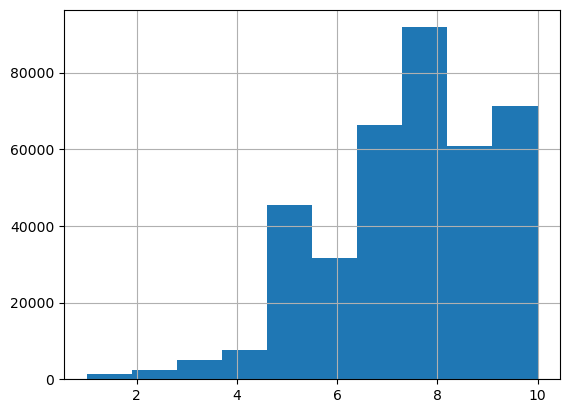

In [232]:
rating_df[rating_df['Book-Rating'] > 0]['Book-Rating'].hist(bins = 10)

<Axes: >

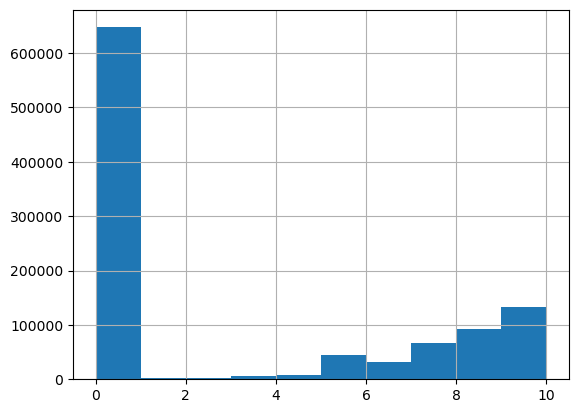

In [233]:
# 평점 히스토그램
rating_df['Book-Rating'].hist()

In [234]:
nonZero = rating_df[rating_df['Book-Rating'] != 0]
hasAge = user_df[user_df['Age'] >= 0][['User-ID', 'Age']]
hasAge

,User-ID,Age
1,2,18.0
3,4,17.0
5,6,61.0
9,10,26.0
10,11,14.0
...,...,...
278848,278849,23.0
278850,278851,33.0
278851,278852,32.0
278852,278853,17.0


In [235]:
nonZeroAge = nonZero.merge(hasAge, on = 'User-ID')
nonZeroAge.groupby('Age').mean()

C:\Users\User\AppData\Local\Temp\ipykernel_11484\398543370.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  nonZeroAge.groupby('Age').mean()


,User-ID,Book-Rating
Age,,
0.0,131180.763285,7.748792
1.0,153103.335000,7.415000
2.0,136315.051813,7.010363
3.0,168148.321429,8.380952
4.0,203674.012579,7.893082
...,...,...
228.0,202452.500000,7.750000
229.0,172058.000000,7.333333
237.0,58286.000000,5.000000


In [236]:
nonZeroAge = nonZeroAge[(8 <= nonZeroAge['Age']) & (nonZeroAge['Age'] <= 80)]
nonZeroAge.groupby('Age').count()[['User-ID']].to_csv('tmp.csv')

# SVD

In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix # array도 있음

In [238]:
rating_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,2313,034545104X,5
2,6543,034545104X,0
3,8680,034545104X,5
4,10314,034545104X,9
...,...,...,...
1031170,276688,0517145553,0
1031171,276688,1575660792,7
1031172,276690,0590907301,0
1031173,276704,0679752714,0


In [239]:
# linalg.svds 연산할 때 float여야 한다고 한다.
rating_df['Book-Rating'] = rating_df['Book-Rating'].apply(float)
rating_df

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0.0
1,2313,034545104X,5.0
2,6543,034545104X,0.0
3,8680,034545104X,5.0
4,10314,034545104X,9.0
...,...,...,...
1031170,276688,0517145553,0.0
1031171,276688,1575660792,7.0
1031172,276690,0590907301,0.0
1031173,276704,0679752714,0.0


In [290]:
rating_df['User-ID'].unique()

array([276725,   2313,   6543, ..., 276618, 276647, 276660], dtype=int64)

In [240]:
# sparse matrix 만들때는 행, 열 id가 모두 0부터 시작하는 연속적인 숫자여야 한다.
# 연속적인 숫자로 만들어야 하는데, 그냥 무작위로 만들어버리면 원본 데이터와 연결이 안되므로
# mapping table을 미리 만들어 둔다.
u_id = rating_df['User-ID'].unique()
user2idx = {org : new for new, org in enumerate(u_id)}
b_id = rating_df['ISBN'].unique()
book2idx = {org : new for new, org in enumerate(b_id)}


rating_df['u_idx'] = rating_df['User-ID'].map(user2idx) # apply는 복잡한거 할 때, map은 category 단순 매핑할때 사용
rating_df['b_idx'] = rating_df['ISBN'].map(book2idx)
rating_df

,User-ID,ISBN,Book-Rating,u_idx,b_idx
0,276725,034545104X,0.0,0,0
1,2313,034545104X,5.0,1,0
2,6543,034545104X,0.0,2,0
3,8680,034545104X,5.0,3,0
4,10314,034545104X,9.0,4,0
...,...,...,...,...,...
1031170,276688,0517145553,0.0,14593,270165
1031171,276688,1575660792,7.0,14593,270166
1031172,276690,0590907301,0.0,22953,270167
1031173,276704,0679752714,0.0,22505,270168


In [241]:
# sparse matrix 만들 때 전체 shape이 어떻게 되는지 지정해야 한다.
# 전체 행, 열 갯수 지정하려고 nunique 사용-
num_user = rating_df['u_idx'].nunique()
num_book = rating_df['b_idx'].nunique()

In [431]:
# train, valid, test split : 8:1:1
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(rating_df, test_size = 0.5, random_state = 1004)

In [432]:
# sparse matrix 만들기, csr
from scipy.sparse import csr_matrix
sparse_df = coo_matrix((train_df['Book-Rating'], (train_df['u_idx'], train_df['b_idx'])), 
                shape = (num_user, num_book))

In [429]:
# 행렬 분해, U, S, V는 ndarray
from scipy.sparse import linalg
U, S, V = linalg.svds(sparse_df, k = 30)

In [411]:
# target 유저의 영화 선호도 예측 정보 가져온다.
import warnings
warnings.filterwarnings("ignore")
# 11676
target_user_idx = 20
for kk in range(50, 101, 10):
    U, S, V = linalg.svds(sparse_df, k = kk, random_state = 100)
    
    err = []
    for i in range(0, num_user, 1000):
        pred = U[i] @ np.diag(S) @ V

        # target_df 만들기
        target_rated_df = train_df[train_df['u_idx'] == i]
        target_rated_df['pred'] = pred[target_rated_df['b_idx'].to_list()]*10**17

        err.append(target_rated_df[['Book-Rating']].corrwith(target_rated_df['pred']).values[0])
    print(np.mean(err))

SyntaxError: invalid syntax (4095044066.py, line 7)

In [438]:
for i in range(1, 9):
    U, S, V = linalg.svds(sparse_df, k = i, random_state = 100)

    err = []
    pred = U[i] @ np.diag(S) @ V

    # target_df 만들기
    target_rated_df = train_df[train_df['u_idx'] == user2idx[264321]]
    target_rated_df['pred'] = pred[target_rated_df['b_idx'].to_list()]

    target_rated_df['Book-Rating'] = target_rated_df[['Book-Rating']]
    print(i, target_rated_df[['Book-Rating']].corrwith(target_rated_df['pred']).values[0])

1 0.03818652540539244
2 0.051218755366853067
3 0.04898137655095752
4 0.0962256487663229
5 0.17706888594914597
6 -0.08450337868296381
7 0.1312856193382535
8 0.054072249572955276


In [439]:
U, S, V = linalg.svds(sparse_df, k = 2000, random_state = 100)

err = []
pred = U[i] @ np.diag(S) @ V +

# target_df 만들기
target_rated_df = train_df[train_df['u_idx'] == user2idx[264321]]
target_rated_df['pred'] = pred[target_rated_df['b_idx'].to_list()]

target_rated_df['Book-Rating'] = target_rated_df[['Book-Rating']]
print(i, target_rated_df[['Book-Rating']].corrwith(target_rated_df['pred']).values[0])

KeyboardInterrupt: 

In [ ]:
# rating 평균 상위 top5
nonzero_rating = rating_df[rating_df['Book-Rating'] >= 1] #평점 1점 이상인 데이터들만 저장
nonzero_sort = nonzero_rating.groupby('ISBN').count().sort_values('Book-Rating', ascending = False)
review_over10 = nonzero_sort[nonzero_sort['User-ID'] >= 10].reset_index() #평점 1이상이면서, 리뷰 10개 이상인 책
review_over10 = review_over10.drop('User-ID', axis = 1) #유저아이디 제거
review_over10.rename(columns = {'Book-Rating' : 'Rating-Count'}, inplace = True) #column명 변경
#평점 1이상이면서, 리뷰 10개 이상인 책들의 평균평점 구하기
total_rating = pd.merge(nonzero_rating, review_over10, on = 'ISBN', how = 'inner')
total_recom = total_rating.groupby('ISBN').mean().sort_values('Book-Rating', ascending = False).reset_index()
print('평균 평점이 가장 높은 Top 5')
for i in range(5): #상위 5개 추출
    print(f'{i+1}번째 추천', total_recom.iloc[i]['ISBN'])

In [ ]:
# 베스트셀러
for target_user_idx in [88705, 264321, 182459, 161936, 226482, 11676, 198711]:
    # best seller rating 0 포함
    book_sold = rating_df.groupby('ISBN').count().sort_values('Book-Rating', ascending = False)[['Book-Rating']]
    book_sold
    # 유저가 읽은 책을 추천 책에서 빼야 한다.
    # target_user_idx = 264321
    target_user_read_df = rating_df[rating_df['User-ID'] == target_user_idx]
    target_user_read_df
    # 책 best seller rating 0 포함 - 읽었던 책은 뺌
    book_sold.reset_index(inplace = True)
    target_notread_best_seller_df = book_sold[~book_sold['ISBN'].isin(target_user_read_df['ISBN'])] # best seller 중 target 유저가 안 읽은 책들
    top3_target_notread_best_seller_df = target_notread_best_seller_df[:5]
    print(f'{target_user_idx}님의 책 추천 top3 =')
    print(top3_target_notread_best_seller_df, end ='\n'*2)